In [27]:
import re
import os
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal

# code for sorting excel files by human order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# folder with the data
folder = '../experiment_data/max_death_rate_10312023'

# each genotype is associated with a tuple corresponding to the excel sheet number and the list of rows
exp_layout = {0:(0,['B','C','D']), 
              3:(0,['E','F','G']),
              5:(1,['B','C','D']),
              9:(1,['E','F','G']),
              10:(2,['B','C','D'])}

time = np.array([0,15,48,60,80,115,150,210,270,330])

# get the rfu30 to dilution factor calibration curve
rfu30_to_dilution = cal.run()

In [28]:
# takes a fodler of excel files and returns a list of plates and a list of data
def get_timeseries(folder_path,plate_num):
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

plate,data = get_timeseries(folder,plate_num=0)

In [29]:
mean_dict = {}
err_dict = {}

cell_count_mean = {}
cell_count_err = {}
cell_count_log_err = {}

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    plate,data = get_timeseries(folder,plate_num=exp_layout[exp_key][0])

    time_list = []

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        data_t = np.zeros((3,10))
        row_indx = 0
        for row in exp_layout[exp_key][1]:
            for col in range(10):
                key = row + str(col+2)
                data_t[row_indx,col] = data[i][key]
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t)*10**6
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)


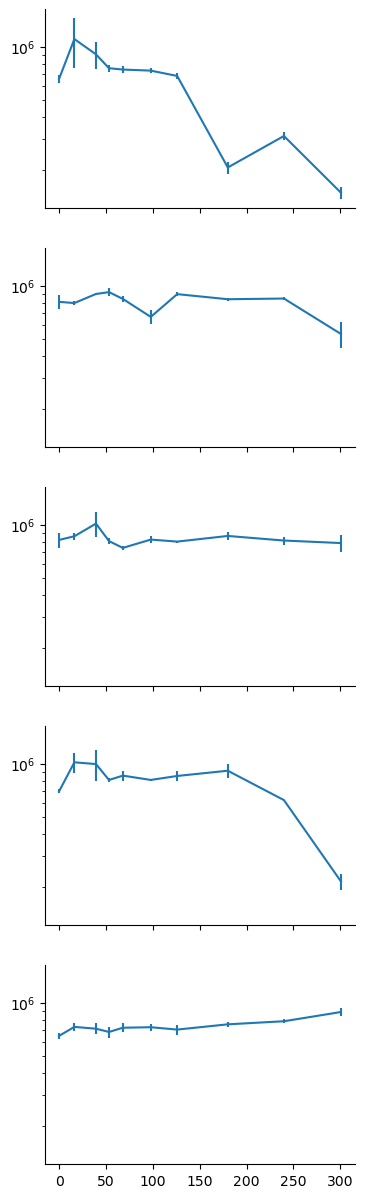

In [30]:
fig,ax_list = plt.subplots(nrows=5,figsize=(4,15),sharex=True,sharey=True)
# fig,ax = plt.subplots()

indx = 0
for key in cell_count_mean.keys():
    ax = ax_list[indx]
    ax.errorbar(time,cell_count_mean[key],yerr=cell_count_err[key])
    ax.set_yscale('log')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    indx+=1
    

Text(0, 0.5, 'Normalized cell count (log10)')

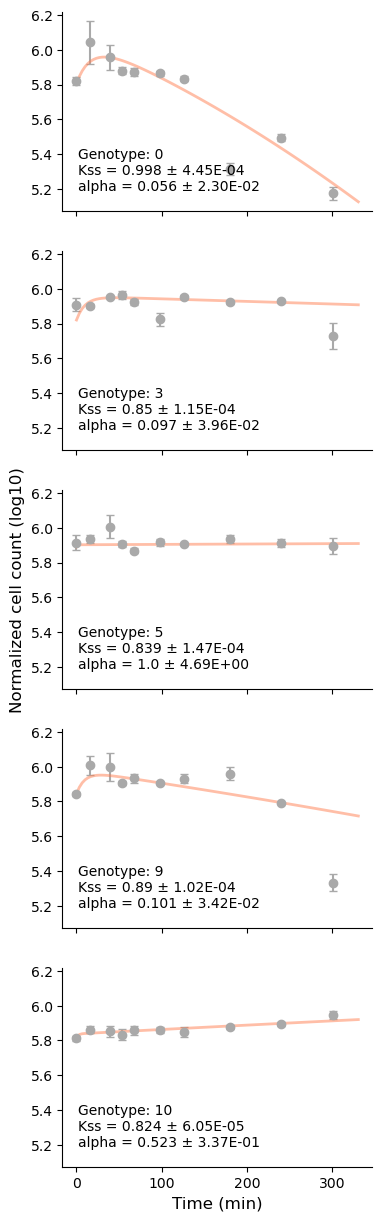

In [34]:
fig,ax_list = plt.subplots(nrows=5,figsize=(4,15),sharex=True,sharey=True)

cmap = mpl.colormaps['viridis']
def growth_diffeq(N,t,K,Kss,alpha,cc):

    dydt = (K-Kss*(1-np.exp(-alpha*t)))*N*(1-N/cc)

    return dydt

def growth_sol(t,y0,K,Kss,alpha,cc):
    y = odeint(growth_diffeq,y0,t,args=(K,Kss,alpha,cc))
    return y[:,0]

cc = 7
K = 0.014

xfit = np.linspace(0,np.max(time+30),100)

row_indx = 0

for key in cell_count_mean.keys():
    ax = ax_list[row_indx]

    y = np.log10(cell_count_mean[key])
    # y = y-y[0] + 2

    ax.errorbar(time,y,yerr=cell_count_log_err[key],fmt='o',color='darkgrey',capsize=3)

    p0 = [2,0.1,0.1]
    bounds = [[1,0,0],[7,1,1]]

    popt,pcov = curve_fit(lambda time, y0, Kss, alpha: growth_sol(time,y0, K,Kss,alpha,cc),
                        time,y,p0=p0,maxfev=10000,bounds=bounds, sigma=cell_count_log_err[key])
    
    y0 = popt[0]
    Kss = popt[1]
    alpha = popt[2]
    yfit = growth_sol(xfit,y0,K,Kss,alpha,cc)

    ax.plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.5)

    err = np.sqrt(np.diag(pcov))

    ax.annotate('Genotype: ' + str(key) + '\n' + 'Kss = ' + str(np.round(Kss*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
                'alpha = ' + str(np.round(alpha,3)) + " ± " + f"{err[2]:.2E}", xy=(0.05,0.1),xycoords='axes fraction',fontsize=10)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    row_indx += 1

ax_list[-1].set_xlabel('Time (min)',fontsize=12)
ax_list[2].set_ylabel('Normalized cell count (log10)',fontsize=12)

Text(0, 0.5, 'Normalized cell count (log10)')

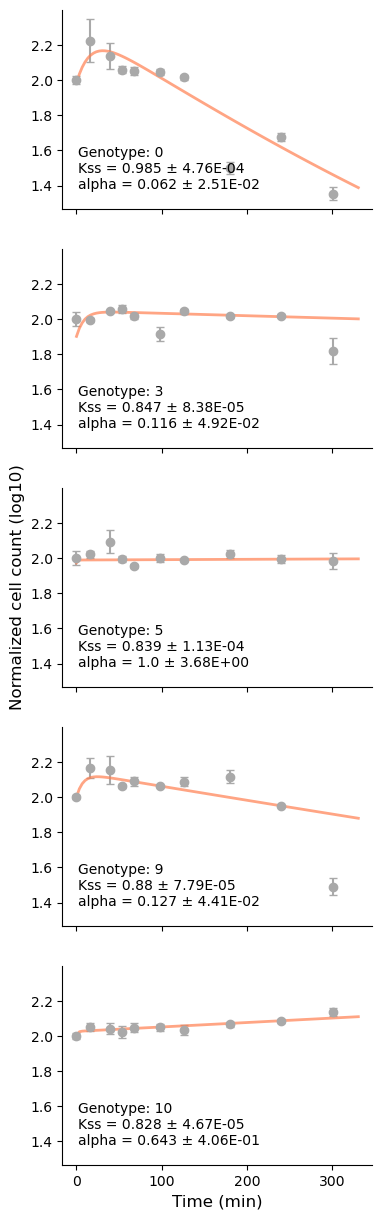

In [32]:
fig,ax_list = plt.subplots(nrows=5,figsize=(4,15),sharex=True,sharey=True)

cmap = mpl.colormaps['viridis']
def growth_diffeq(N,t,K,Kss,alpha,cc):

    dydt = (K-Kss*(1-np.exp(-alpha*t)))*N*(1-N/cc)

    return dydt

def growth_sol(t,y0,K,Kss,alpha,cc):
    y = odeint(growth_diffeq,y0,t,args=(K,Kss,alpha,cc))
    return y[:,0]

cc = 5
K = 0.014

xfit = np.linspace(0,np.max(time+30),100)

row_indx = 0

for key in cell_count_mean.keys():
    ax = ax_list[row_indx]

    y = np.log10(cell_count_mean[key])
    y = y-y[0] + 2

    ax.errorbar(time,y,yerr=cell_count_log_err[key],fmt='o',color='darkgrey',capsize=3)

    p0 = [2,0.1,0.1]
    bounds = [[1,0,0],[3,1,1]]

    popt,pcov = curve_fit(lambda time, y0, Kss, alpha: growth_sol(time,y0, K,Kss,alpha,cc),
                        time,y,p0=p0,maxfev=10000,bounds=bounds,sigma=cell_count_log_err[key])
    
    y0 = popt[0]
    Kss = popt[1]
    alpha = popt[2]
    yfit = growth_sol(xfit,y0,K,Kss,alpha,cc)

    ax.plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.7)

    err = np.sqrt(np.diag(pcov))

    ax.annotate('Genotype: ' + str(key) + '\n' + 'Kss = ' + str(np.round(Kss*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
                'alpha = ' + str(np.round(alpha,3)) + " ± " + f"{err[2]:.2E}", xy=(0.05,0.1),xycoords='axes fraction',fontsize=10)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    row_indx += 1

ax_list[-1].set_xlabel('Time (min)',fontsize=12)
ax_list[2].set_ylabel('Normalized cell count (log10)',fontsize=12)